In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import utils, transforms
from torchvision.transforms import ToTensor

In [2]:
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
import random

class DataLoaderSegmentation(Dataset):
    def __init__(self, path, labels, transforms = None):
      super(DataLoaderSegmentation, self).__init__()
      self.rgb_array = []
      self.mask_array = []
      self.labels = labels
      self.transforms = transforms

      for i in range(len(path)):
        image_path_list = sorted(glob.glob(os.path.join(path[i], 'rgb/*.png')))
        mask_path_list = sorted(glob.glob(os.path.join(path[i], 'semantic/*.npy')))
        
        for j in range(len(image_path_list)):
          image_path =  image_path_list[j]
          mask_path = mask_path_list[j]
          rgb = np.array(Image.open(image_path))
          mask = np.load(mask_path)

          self.rgb_array.append(rgb)
          self.mask_array.append(mask)

        '''
        instance_id_to_semantic_label_id = np.array(self.annotation_list[i]["id_to_label"])
        semantic_id_to_name = self.build__semantic_id_name_dict(self.annotation_list[i])

        rgb, mask = self.data_processing(image_path_list, mask_path_list, instance_id_to_semantic_label_id, semantic_id_to_name)
        

        self.rgb_array.extend(rgb)
        self.mask_array.extend(mask)
        '''


    def __getitem__(self, index):
      data = self.rgb_array[index]
      true_mask = self.mask_array[index]

      output = {'rgb': data[:, :, :3], 'truth': true_mask.astype(int)}

      seed = np.random.randint(2147483647)
      
      random.seed(seed)
      torch.manual_seed(seed)
      if self.transforms:
        output['rgb'] = self.transforms(output['rgb'])
          
      random.seed(seed)
      torch.manual_seed(seed)
      if self.transforms:
        output['truth'] = self.transforms(output['truth']).squeeze(0)
      
      return output


    def __len__(self):
      return len(self.rgb_array)


    def get_class_labels(self, mask):
      return self.map_to_class_labels(mask)

    '''
    def build__semantic_id_name_dict(self, annotations):
      semantic_id_to_name = {}

      for i in range(len(annotations['classes'])):
        id = annotations['classes'][i]['id']
        name = annotations['classes'][i]['name']
        semantic_id_to_name[id] = name

      return semantic_id_to_name


    def data_processing(self, image_path_list, mask_path_list, instance_id_to_semantic_label_id, semantic_id_to_name):
      rgb, truth = [], []

      for i in range(len(image_path_list)):
        image_path = image_path_list[i]
        mask_path = mask_path_list[i]
        data = Image.open(image_path)
        raw_semantic_output = np.load(mask_path)

        data = np.array(data)
        true_mask = instance_id_to_semantic_label_id[raw_semantic_output]
        
        for j in range(len(true_mask)):
          for k in range(len(true_mask)):
            semantic_id = true_mask[j, k]
            tmp_name = semantic_id_to_name.get(semantic_id)
            if tmp_name in self.labels.keys():     
              costum_id = self.labels.get(tmp_name)
              true_mask[j, k] = costum_id
            else:
              true_mask[j, k] = 0

        rgb.append(data[:, :, :3])
        truth.append(true_mask.astype(int))

      return rgb, truth
    '''

    def print_label_distribution(self):
      for cnt, true_mask in enumerate(self.mask_array):        
        unique, counts = np.unique(true_mask, return_counts=True)
        tmp = dict(zip(unique, counts))
        total = sum(tmp.values())
        tmp = {k: round(v / total, 3) for k, v in tmp.items()}
        
        try:
          if tmp[0] > 0.4:
            print(cnt, tmp)
        except:
          continue

In [3]:
import json

dataset_name = 'all_575P_100E_24C_v2'
path = sorted(glob.glob(f'./hw2_data/hw2_scene/{dataset_name}/*'))
'''
data_name = ['frl_apartment_0', 'frl_apartment_1', 'room_0', 'room_1']
annotations = []

for name in data_name:
    with open(f"../../../../../data/scene_datasets/{name}/habitat/info_semantic.json", "r") as f:
        tmp = json.load(f)
        annotations.append(tmp)
'''
  
labels = {  'background': 0,
            'picture': 1,
            'cushion': 2,
            'cabinet': 3,
            'vase': 4,
            'wall-plug': 5,
            'lamp': 6,
            'plate': 7,
            'basket': 8,
            'door': 9,
            'floor': 10,
            'pot': 11,
            'sofa': 12,
            'bed': 13,
            'ceiling': 14,
            'rug': 15,
            'book': 16,
            'blinds': 17,
            'chair': 18,
            'wall': 19,
            'switch': 20,
            'indoor-plant': 21,
            'plant-stand': 22,
            'table': 23,
            'stair': 24,
        }

transform = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip()])

dataset = DataLoaderSegmentation(path, labels, transforms = transform)

In [4]:
dataset.print_label_distribution()

25 {0: 0.406, 1: 0.0, 2: 0.0, 3: 0.0, 5: 0.0, 6: 0.001, 7: 0.0, 9: 0.175, 10: 0.111, 11: 0.0, 15: 0.001, 18: 0.001, 19: 0.295, 20: 0.0, 21: 0.002, 22: 0.001, 23: 0.006}
26 {0: 0.437, 1: 0.0, 2: 0.0, 3: 0.001, 5: 0.0, 6: 0.001, 7: 0.0, 9: 0.044, 10: 0.111, 11: 0.0, 15: 0.002, 18: 0.001, 19: 0.391, 20: 0.001, 21: 0.002, 22: 0.001, 23: 0.008}
28 {0: 0.426, 3: 0.101, 10: 0.01, 14: 0.03, 18: 0.031, 19: 0.403}
29 {0: 0.55, 2: 0.002, 3: 0.03, 4: 0.0, 6: 0.004, 7: 0.002, 8: 0.001, 9: 0.016, 10: 0.156, 11: 0.001, 12: 0.006, 15: 0.047, 16: 0.0, 17: 0.018, 18: 0.001, 19: 0.139, 21: 0.005, 22: 0.002, 23: 0.019}
30 {0: 0.53, 2: 0.002, 3: 0.036, 4: 0.001, 6: 0.005, 7: 0.002, 8: 0.001, 9: 0.018, 10: 0.143, 11: 0.001, 12: 0.006, 15: 0.056, 16: 0.0, 17: 0.014, 18: 0.001, 19: 0.152, 21: 0.006, 22: 0.003, 23: 0.024}
31 {0: 0.504, 2: 0.002, 3: 0.045, 4: 0.001, 6: 0.006, 7: 0.003, 8: 0.001, 9: 0.02, 10: 0.143, 11: 0.001, 12: 0.007, 15: 0.048, 16: 0.0, 17: 0.012, 18: 0.001, 19: 0.165, 21: 0.006, 22: 0.003, 

In [5]:
batch_size = 4
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

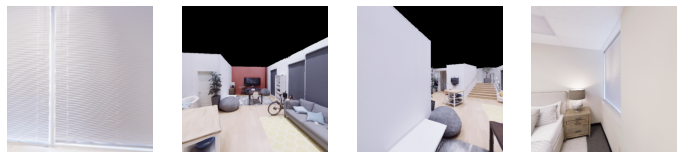

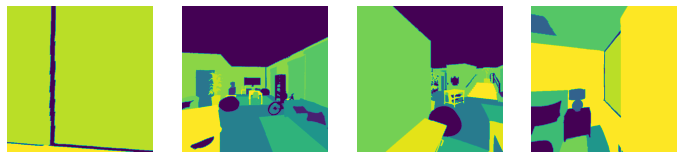

In [6]:
def show_batch(sample_batch):
    def show_row(imgs, batch_size, img_type):
        plt.figure(figsize=(12, 8))
        for i, img in enumerate(imgs):
            ax = plt.subplot(1, batch_size, i + 1)
            ax.axis("off")
            if img_type == 'rgb':
                plt.imshow(img.numpy().transpose(1, 2, 0))
            elif img_type == 'truth':
                plt.imshow(img.numpy())

        plt.show()

    batch_size = len(sample_batch['rgb'])
    for k in sample_batch.keys():
        show_row(sample_batch[k], batch_size, k)

_, sample_batch = next(enumerate(dataloader))
show_batch(sample_batch)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels , in_channels // 2,
                kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# We have 3 input channels (rgb) and 6 classes we want to semantically segment
model = UNet(n_channels = 3, n_classes = 25)

In [8]:
torch.cuda.is_available()

True

In [9]:
from torch import optim

num_epochs = 150
lr = 0.0001
val_check = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        imgs = batch['rgb']
        true_masks = batch['truth']

        # Move the images and truth masks to the proper device (cpu or gpu)
        imgs = imgs.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device, dtype=torch.long)

        # Get the model prediction
        masks_pred = model(imgs)

        # Evaluate the loss, which is Cross-Entropy in our case
        loss = criterion(masks_pred, true_masks)
        epoch_loss += loss.item()

        # Update the model parameters
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), 0.1)
        optimizer.step()

    # Evaluate the model on validation set
    if epoch % val_check == 0:
      print(f'Epoch[{epoch+1}/{num_epochs}], Loss: {epoch_loss: .4f}')

    # checkpoints
    if epoch % 5 == 0:
      state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss,
        }
      filepath = f"./hw2_data/hw2_model/{dataset_name}/model_{epoch}epoch.pt"
      torch.save(state, filepath)

/home/panhan/anaconda3/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch[1/150], Loss:  247.4205
Epoch[2/150], Loss:  190.4675
Epoch[3/150], Loss:  162.3170
Epoch[4/150], Loss:  141.5468
Epoch[5/150], Loss:  124.8427
Epoch[6/150], Loss:  113.0847
Epoch[7/150], Loss:  101.8345
Epoch[8/150], Loss:  95.5652
Epoch[9/150], Loss:  93.5693
Epoch[10/150], Loss:  79.3338
Epoch[11/150], Loss:  79.0908
Epoch[12/150], Loss:  69.3542
Epoch[13/150], Loss:  71.5514
Epoch[14/150], Loss:  62.6455
Epoch[15/150], Loss:  57.1564
Epoch[16/150], Loss:  57.5729
Epoch[17/150], Loss:  54.7149
Epoch[18/150], Loss:  48.7762
Epoch[19/150], Loss:  46.9326
Epoch[20/150], Loss:  46.9135
Epoch[21/150], Loss:  39.7862
Epoch[22/150], Loss:  40.3873
Epoch[23/150], Loss:  38.7423
Epoch[24/150], Loss:  34.3488
Epoch[25/150], Loss:  35.7073
Epoch[26/150], Loss:  31.3519
Epoch[27/150], Loss:  33.4695
Epoch[28/150], Loss:  30.8628
Epoch[29/150], Loss:  27.3403
Epoch[30/150], Loss:  26.1563
Epoch[31/150], Loss:  27.8044
Epoch[32/150], Loss:  24.4238
Epoch[33/150], Loss:  24.8382
Epoch[34/150

In [10]:
state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': loss,
    }
filepath = f"./hw2_data/hw2_model/{dataset_name}/model_150epoch.pt"
torch.save(state, filepath)

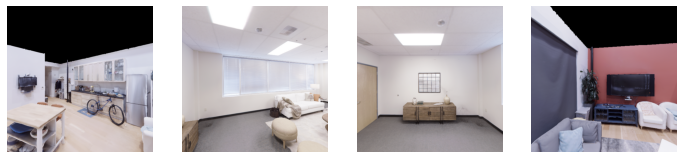

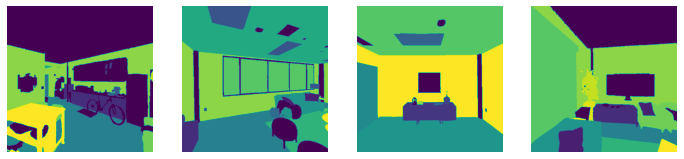

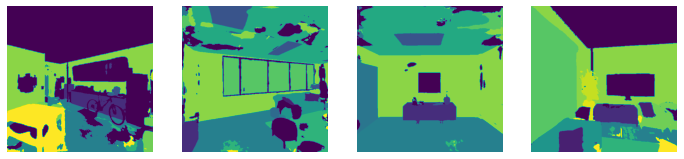

In [11]:
import torch.nn.functional as F

def show_batch(sample_batch):
    def show_row(imgs, batch_size, img_type):
        plt.figure(figsize=(12, 8))
        for i, img in enumerate(imgs):
            ax = plt.subplot(1, batch_size, i + 1)
            ax.axis("off")
            if img_type == 'rgb':
                plt.imshow(img.numpy().transpose(1, 2, 0))
            elif img_type in ['truth', 'prediction']:
                plt.imshow(img.numpy())

        plt.show()

    batch_size = len(sample_batch['rgb'])
    for k in sample_batch.keys():
        show_row(sample_batch[k], batch_size, k)


with torch.no_grad():
    model.to('cpu')
    model.eval()
    _, batch = next(enumerate(dataloader))
    mask_pred = model(batch['rgb'])
    mask_pred = F.softmax(mask_pred, dim=1)
    mask_pred = torch.argmax(mask_pred, dim=1)

    batch['prediction'] = mask_pred

    show_batch(batch)

In [12]:
from habitat_sim.utils.common import d3_40_colors_rgb
from PIL import Image
import cv2

def transform_semantic(semantic_obs):
    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGB")
    semantic_img = cv2.cvtColor(np.asarray(semantic_img), cv2.COLOR_RGB2BGR)

    return semantic_img

for filename in range(1, 153):
    img = cv2.imread("../../data/test_v3/rgb/step"+str(filename)+".png")
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    transform1 = transforms.Compose([transforms.ToTensor(),])
    img_t = transform1(img)
    img_t = torch.unsqueeze(img_t, 0)

    output = model(img_t)
    output = F.softmax(output, dim = 1)
    output = torch.argmax(output, dim = 1)
    output = np.squeeze(output, 0)
    
    np.save(f'./hw2_data/hw2_predict/{dataset_name}/numpy/step{filename}.npy', output.numpy(), allow_pickle = True)
    
    tmp = transform_semantic(output.numpy())
    cv2.imwrite(f'./hw2_data/hw2_predict/{dataset_name}/picture/pic{filename}.png', tmp)